In [65]:
import tensorflow as tf
import numpy as np
from tensorflow.layers import Flatten
from preprocess import regularts
import pandas as pd
from pickles import pickling
from numpy import random
import matplotlib.pyplot as plt

In [66]:
from utils import config
from load import train

In [67]:
train.load_metadata()
train.load_set()

training_set = config.training_set
training_set_metadata =config.training_set_metadata

[LOAD] Load metadata for training dataset


In [68]:
train_ts_df = pickling.unpickle_processed_train()
x_ts_tensor = regularts.tensorize_regular_ts(train_ts_df)
x_ts_tensor_std = regularts.standardize_regularts(x_ts_tensor)

In [69]:
targets = pd.get_dummies(training_set_metadata.target)
targets = pd.get_dummies(targets)
targets[99] = 0
y_tensor = targets.values

# TensorFlow Model

In [76]:
tf.reset_default_graph()

In [77]:
ts_shape = (56,6)
output_size = 15

## Placeholders definition

In [78]:
x_ts = tf.placeholder(tf.float32,[None,ts_shape[0],ts_shape[1]],name = "x_ts_placeholder")

In [79]:
y = tf.placeholder(tf.float32,[None,output_size],name = "y_placeholder")

## Network definition

### Convolution 1

### Max pooling 1

### Convolution 2

### Flatten

### Dense

In [80]:
model_name = "4convpool1"



convolved1 = tf.layers.conv1d(
    inputs=x_ts,
    filters=40,
    strides=1,
    kernel_size=3,
    padding="VALID",
    activation=tf.nn.relu,
    name="convolution-1")

pooled1 = tf.layers.max_pooling1d(
    inputs=convolved1,
    pool_size=2,
    strides=2,
    name="max_pool-1")

convolved2 = tf.layers.conv1d(
    inputs=pooled1,
    filters=60,
    strides=1,
    kernel_size=2,
    padding="VALID",
    name="convolution-2")

pooled2 = tf.layers.max_pooling1d(
    inputs=convolved2,
    pool_size=2,
    strides=2,
    name="max_pool-2")

convolved3 = tf.layers.conv1d(
    inputs=pooled2,
    filters=80,
    strides=1,
    kernel_size=2,
    padding="VALID",
    name="convolution-3")

pooled3 = tf.layers.max_pooling1d(
    inputs=convolved3,
    pool_size=2,
    strides=2,
    name="max_pool-3")

convolved4 = tf.layers.conv1d(
    inputs=pooled3,
    filters=100,
    strides=1,
    kernel_size=4,
    padding="VALID",
    name="convolution-4")

pooled4 = tf.layers.max_pooling1d(
    inputs=convolved4,
    pool_size=2,
    strides=2,
    name="max_pool-4")

flat_layer = Flatten()(pooled4)

predict_logits = tf.layers.dense(
    inputs=flat_layer,
    units=output_size,
    name="predict_logits"
)


### Sigmoid

In [81]:
predict = tf.sigmoid(predict_logits,name="predict")

## Loss definition

In [82]:
learning_rate = 0.0001
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)))
    return loss

loss = mywloss(y,predict_logits)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
train = optimizer.minimize(loss)  

# Tensorflow Training

In [83]:
def get_batch(x_ts_tensor,y_tensor,batch_size,epoch):
    start_index = (batch_size * epoch) % x_ts_tensor.shape[0]
    end_index = (batch_size * (epoch+1)) % x_ts_tensor.shape[0]
    if end_index < start_index:
        x_ts_batch = np.concatenate([x_ts_tensor[start_index:],x_ts_tensor[:end_index]])
        y_batch = np.concatenate([y_tensor[start_index:],y_tensor[:end_index]])
    else:
        x_ts_batch = x_ts_tensor[start_index:end_index]
        y_batch = y_tensor[start_index:end_index]
    return x_ts_batch,y_batch
        

In [84]:
np.array([9,5,4,6,8,5,2,4,5])[[i not in [0,1] for i in range(9)]]

array([4, 6, 8, 5, 2, 4, 5])

In [85]:
train_indices = random.rand(x_ts_tensor.shape[0]) < 0.5
1 - train_indices

array([0, 0, 1, ..., 1, 1, 1])

In [86]:
x_ts_train.shape

(7187, 56, 6)

In [87]:
def separate_train_test(x_ts_tensor,y_tensor,test_select_start_index,test_select_end_index):
    x_ts_test = x_ts_tensor[test_select_start_index:test_select_end_index]
    y_test = y_tensor[test_select_start_index:test_select_end_index]
    x_ts_train = np.concatenate([x_ts_tensor[:test_select_start_index],x_ts_tensor[test_select_end_index:]])
    y_train = np.concatenate([y_tensor[:test_select_start_index],y_tensor[test_select_end_index:]])
    return x_ts_train,y_train,x_ts_test,y_test

In [88]:
def separate_train_test_random(x_ts_tensor,y_tensor,train_proportion):
    train_indices = random.rand(x_ts_tensor.shape[0]) < train_proportion
    x_ts_train = x_ts_tensor[train_indices]
    y_train = y_tensor[train_indices]
    x_ts_test = x_ts_tensor[1- train_indices]
    y_test = y_tensor[1- train_indices]
    return x_ts_train,y_train,x_ts_test,y_test

In [89]:
def get_batch_random(x_ts_tensor,y_tensor,batch_proportion):
    train_indices = random.rand(x_ts_tensor.shape[0]) < batch_proportion
    x_train_batch = x_ts_tensor[train_indices]
    y_train_batch = y_tensor[train_indices]
    return x_train_batch,y_train_batch

<IPython.core.display.Javascript object>


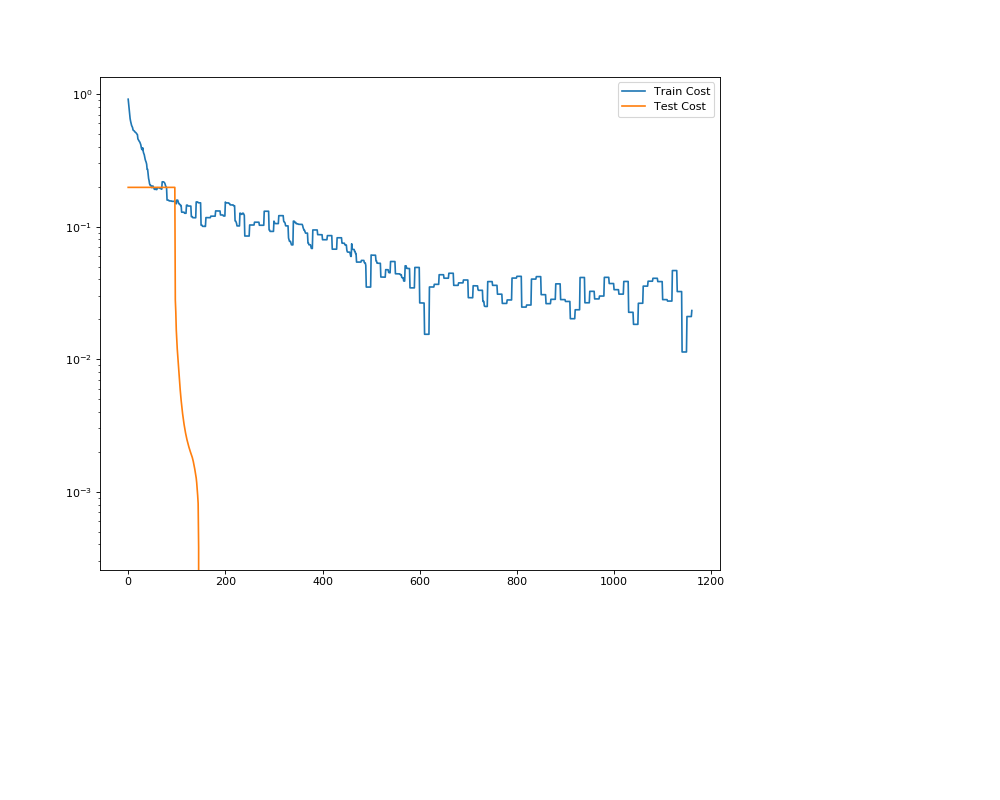

In [ ]:
saver = tf.train.Saver()
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    
    %matplotlib notebook
    
    
    fig = plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    
    x_ts_train,y_train,x_ts_test,y_test = separate_train_test_random(x_ts_tensor,y_tensor,7200/7848)
    epoch_number = 10000
    
    train_loss_list = []
    test_loss_list = []
    
    # >> Training part
    for i_epoch in range(epoch_number+1):
        if i_epoch % 10 == 0:
            train_batch_x,train_batch_y = get_batch_random(x_ts_train,y_train,1000/7200)

        train_loss = sess.run(loss, feed_dict={x_ts:train_batch_x, y:train_batch_y})
        test_loss = sess.run(loss, feed_dict={x_ts:x_ts_test, y:y_test})
#         print("")
#         print("Iteration ", i_epoch, " - Train Loss = ", train_loss)
#         print(" >> Test loss  = ",test_loss )

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

        if i_epoch % 20 == 0:

            ax.clear()
            ax.semilogy(train_loss_list, label="Train Cost") 
            ax.semilogy(test_loss_list, label="Test Cost")   
            plt.legend()    
            fig.canvas.draw()


        sess.run(train, feed_dict={
            x_ts: train_batch_x,
            y: train_batch_y,
        })
        if (i_epoch % 1000 == 0):
             saver.save(sess,'./models/{}/trained_at_epoch_{}'.format(model_name,i_epoch))
    
    x_ts_tensor_test = pickling.unpickle_chunk_processed_tf(0)
    predictions = sess.run(predict,feed_dict = {x_ts:x_ts_tensor})

In [ ]:
predictions[1]

In [ ]:
y_tensor

In [36]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('./models/{}/trained_at_epoch_{}.meta'.format(model_name,i_epoch))
    new_saver.restore(sess, tf.train.latest_checkpoint('./models/{}/'.format(model_name)))
    graph = tf.get_default_graph()
    predict = graph.get_tensor_by_name("predict:0")
    x_ts = graph.get_tensor_by_name("x_ts_placeholder:0")
    predictions = sess.run(predict, feed_dict={x_ts:x_ts_tensor})

    

INFO:tensorflow:Restoring parameters from ./models/4convpool1/trained_at_epoch_10000


In [63]:
i = random.randint(7848)
print(np.equal(predictions[i],predictions[i].max()).astype(int))
print(y_tensor[i])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


In [ ]:
predictions[i]

In [ ]:
predictions = sess.run(predict, feed_dict={x_ts:x_ts_tensor})
    for i in range(91):
        x_ts_tensor = pickling.unpickle_chunk_processed_tf(i)
        predictions = sess.run("predict:0",feed_dict = {"x_ts_placeholder:0":x_ts_tensor})
        pickling.pickle_chunk(prefix="pickles/test/predict/prediction_chunk_",chunk=predictions,chunk_id=i)

In [ ]:
y

In [ ]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('./train_at_epoch_5000.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()    
    x_ts_tensor = pickling.unpickle_processed_train_tf()
    predictions = sess.run("predict:0",feed_dict = {"x_ts_placeholder:0":x_ts_tensor})
#         pickling.pickle_chunk(prefix="pickles/test/predict/prediction_chunk_",chunk=predictions,chunk_id=i)
    

In [ ]:
predictions[0]

In [ ]:
col = ['object_id', 'class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95', 'class_99']
print(len(col))
out_data_csv = pd.DataFrame(columns=col)

In [ ]:
metada = pd.read_csv("dataset/test_set_metadata.csv")

In [ ]:
out_data_csv.object_id = metada.object_id

In [ ]:
out_data_csv

In [ ]:
all_predict = pickling.unpickle_chunk(prefix='pickles/test/predict/prediction_chunk_', chunk_id=0)

In [ ]:
for i in range(1,91):
    chunk = pickling.unpickle_chunk(prefix='pickles/test/predict/prediction_chunk_', chunk_id=i)
    all_predict = np.concatenate([all_predict,chunk])

In [ ]:
for i in range(1,16):
    k = col[i]
    out_data_csv[k] = all_predict[:,i-1]

In [ ]:
out_data_csv.to_csv("predict2.csv",index=False)

In [ ]:
# np.expand_dims(np.expand_dims(x_ts_tensor.mean(axis=(1,2)),axis=1),axis=1).shape
x_ts_tensor.std(axis=(1,2)).reshape((x_ts_tensor.shape[0],1,1)).shape

In [ ]:
x_ts_tensor[0].std()